In [11]:
import math
import json
import os

import numpy as np
import zarr
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import joblib

from utils import walk_files

In [2]:
record_files = tuple(walk_files("data", suffix=".hea", prefix=True, remove_suffix=True))
print(len(record_files))

43099


In [3]:
SCORED_CODES = [
    270492004,
    164889003,
    164890007,
    426627000,
    713427006,
    713426002,
    445118002,
    39732003,
    164909002,
    251146004,
    698252002,
    10370003,
    284470004,
    427172004,
    164947007,
    111975006,
    164917005,
    47665007,
    59118001,
    427393009,
    426177001,
    426783006,
    427084000,
    63593006,
    164934002,
    59931005,
    17338001,
]
mlb = MultiLabelBinarizer(classes=SCORED_CODES)

In [4]:
with open("data/snomed_ct_dx_map.json") as f:
    snomed_map = json.load(f)


In [5]:
root = zarr.open_group("data/ecgs.zarr", mode="r")
print(root.tree())
root.info


/
 ├── beats
 │   ├── r_peak_idxs (43099,) object
 │   ├── valid_r_peak_idxs (43099,) object
 │   ├── window_size_400 (43099,) object
 │   ├── window_size_400_normalized (43099,) object
 │   ├── window_size_400_normalized_flattened (801266, 400, 12) float32
 │   ├── window_size_400_outlier (43099,) int32
 │   └── window_size_400_shape (43099, 3) int32
 ├── cleaned
 │   └── p_signal (43099,) object
 ├── meta
 │   └── record_idx_to_window_400_range (1,) object
 ├── raw
 │   ├── dx (43099,) object
 │   ├── meta (43099, 3) int32
 │   ├── p_signal (43099,) object
 │   └── p_signal_shape (43099, 2) int32
 └── seq_embeddings
     ├── version_0 (43099, 768) float64
     ├── version_1 (43099, 768) float64
     ├── version_10 (43099, 768) float64
     ├── version_11 (43099, 768) float64
     ├── version_12 (43099, 768) float64
     ├── version_13 (43099, 768) float64
     ├── version_14 (43099, 768) float64
     ├── version_15 (43099, 768) float64
     ├── version_16 (43099, 768) float64
     ├─

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,5
No. arrays,0
No. groups,5
Groups,"beats, cleaned, meta, raw, seq_embeddings"


In [6]:
# np.where(np.isin(270492004, root["raw/dx"]), root["raw/dx"], False)
feature_indicies = {}
for sc in SCORED_CODES:
    print(f"{sc}, # {snomed_map[str(sc)]}")
    samples = np.nonzero(np.array(list(map(lambda x: np.isin(sc, x), root["raw/dx"]))))[0]
    print(f"{len(samples)} samples")
    feature_indicies[sc] = samples

270492004, # ['IAVB', '1st degree av block']
2394 samples
164889003, # ['AF', 'atrial fibrillation']
3475 samples
164890007, # ['AFL', 'atrial flutter']
314 samples
426627000, # ['Brady', 'bradycardia']
288 samples
713427006, # ['CRBBB', 'complete right bundle branch block']
683 samples
713426002, # ['IRBBB', 'incomplete right bundle branch block']
1611 samples
445118002, # ['LAnFB', 'left anterior fascicular block']
1806 samples
39732003, # ['LAD', 'left axis deviation']
6086 samples
164909002, # ['LBBB', 'left bundle branch block']
1041 samples
251146004, # ['LQRSV', 'low qrs voltages']
556 samples
698252002, # ['NSIVCB', 'nonspecific intraventricular conduction disorder']
997 samples
10370003, # ['PR', 'pacing rhythm']
299 samples
284470004, # ['PAC', 'premature atrial contraction']
1729 samples
427172004, # ['PVC', 'premature ventricular contractions']
188 samples
164947007, # ['LPR', 'Prolonged PR interval']
340 samples
111975006, # ['LQT', 'prolonged qt interval']
1513 samples
16

In [7]:

def get_signal(idx):
    signal = root["raw/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    cleaned_signal = root["cleaned/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    age, sex, fs = root["raw/meta"][idx]
    dx = root["raw/dx"][idx]
    
    beats = root["beats/r_peak_idxs"][idx]
    valid_beats = root["beats/valid_r_peak_idxs"][idx]

#     beat_windows = root["beats/window_size_400"][idx].reshape(root["beats/window_size_400_shape"][idx], order="C")
    beat_windows = root["beats/window_size_400_normalized"][idx].reshape(root["beats/window_size_400_shape"][idx], order="C")
    outlier = root["beats/window_size_400_outlier"][idx]
    bin_dx = mlb.fit_transform([dx,])

    return signal, age, sex, fs, dx #, cleaned_signal, age, sex, fs, dx, bin_dx, beats, valid_beats, beat_windows, outlier


def calculate_tick_range(min_y, max_y, step):
    y_min_offset = min_y % step
    y_max_offset = max_y % step
    return range(int(min_y - y_min_offset), int(max_y - y_max_offset + step), step)


def plot_readable_signal(signal, age, sex, fs, dx):
    names = ["I", "II", "III", "aVR", "aVL", 
             "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    num_samples, num_leads = signal.shape
    duration = fs * len(signal)
    
    x = range(0, duration, duration // num_samples)
    q_x = len(x) // 4    # plot column separator width
    q_y = 4                 # plot row separator height

    plot_leads = {
        "MAIN": signal[:,1],
        "I":    [v + 3 * q_y for v in signal[:, 0]][:q_x],
        "II":   [v + 2 * q_y for v in signal[:, 1]][:q_x],
        "III":  [v + 1 * q_y for v in signal[:, 2]][:q_x],
        "aVR":  [v + 3 * q_y for v in signal[:, 3]][q_x:2 * q_x],
        "aVL":  [v + 2 * q_y for v in signal[:, 4]][q_x:2 * q_x],
        "aVF":  [v + 1 * q_y for v in signal[:, 5]][q_x:2 * q_x],
        "V1":   [v + 3 * q_y for v in signal[:, 6]][2 * q_x:3 * q_x],
        "V2":   [v + 2 * q_y for v in signal[:, 7]][2 * q_x:3 * q_x],
        "V3":   [v + 1 * q_y for v in signal[:, 8]][2 * q_x:3 * q_x],
        "V4":   [v + 3 * q_y for v in signal[:, 9]][3 * q_x:4 * q_x],
        "V5":   [v + 2 * q_y for v in signal[:, 10]][3 * q_x:4 * q_x],
        "V6":   [v + 1 * q_y for v in signal[:, 11]][3 * q_x:4 * q_x]
    }
    
    print([(k, len(v)) for (k, v) in plot_leads.items()])
    y_min = min([min(l) for l in plot_leads.values()])
    y_max = max([max(l) for l in plot_leads.values()])

    fig, ax = plt.subplots(figsize=(10.5, 8.0), dpi=300)

    ax.plot(x, plot_leads["MAIN"])
    ax.set_xticks(range(0, max(x)+1, 40), minor=True)
    ax.set_xticks(range(0, max(x)+1, 200), minor=False)

    # plot columns [I, II, III]
    ax.plot(x[:q_x], plot_leads["I"])
    ax.plot(x[:q_x], plot_leads["II"])
    ax.plot(x[:q_x], plot_leads["III"])
    # plot columns [aVR, aVL, aVF]
    ax.plot(x[q_x:2 * q_x], plot_leads["aVR"])
    ax.plot(x[q_x:2 * q_x], plot_leads["aVL"])
    ax.plot(x[q_x:2 * q_x], plot_leads["aVF"])
    # plot columns [V1, V2, V3]
    ax.plot(x[2 * q_x:3 * q_x], plot_leads["V1"])
    ax.plot(x[2 * q_x:3 * q_x], plot_leads["V2"])
    ax.plot(x[2 * q_x:3 * q_x], plot_leads["V3"])
    # plot columns [V4, V5, V6]
    ax.plot(x[3 * q_x:4 * q_x], plot_leads["V4"])
    ax.plot(x[3 * q_x:4 * q_x], plot_leads["V5"])
    ax.plot(x[3 * q_x:4 * q_x], plot_leads["V6"])

    # set label text for each lead
    q_xd = max(x) // 4
    text_kwargs = {"horizontalalignment": "left",
                   "verticalalignment": "top", "fontsize": 14}
    ax.text(0 * q_xd, 0 * q_y + 200, "II", **text_kwargs)  # MAIN
    ax.text(0 * q_xd, 3 * q_y + 200, "I", **text_kwargs)
    ax.text(0 * q_xd, 2 * q_y + 200, "II", **text_kwargs)
    ax.text(0 * q_xd, 1 * q_y + 200, "III", **text_kwargs)
    ax.text(1 * q_xd, 3 * q_y + 200, "aVR", **text_kwargs)
    ax.text(1 * q_xd, 2 * q_y + 200, "aVL", **text_kwargs)
    ax.text(1 * q_xd, 1 * q_y + 200, "aVF", **text_kwargs)
    ax.text(2 * q_xd, 3 * q_y + 200, "V1", **text_kwargs)
    ax.text(2 * q_xd, 2 * q_y + 200, "V2", **text_kwargs)
    ax.text(2 * q_xd, 1 * q_y + 200, "V3", **text_kwargs)
    ax.text(3 * q_xd, 3 * q_y + 200, "V4", **text_kwargs)
    ax.text(3 * q_xd, 2 * q_y + 200, "V5", **text_kwargs)
    ax.text(3 * q_xd, 1 * q_y + 200, "V6", **text_kwargs)

    # major y-ticks every 100, minor y-ticks every 20. major ticks aligned to 0
    # ax.set_yticks(range(-100, 250+1, 20), minor=True)
    # ax.set_yticks(range(-100, 250+1, 100), minor=False)
    ax.set_yticks(calculate_tick_range(y_min, y_max, 20), minor=True)
    ax.set_yticks(calculate_tick_range(y_min, y_max, 100), minor=False)
    ax.set_xticklabels(())
    ax.set_yticklabels(())

    # set the gridlines
    ax.grid(b=True, which="major", axis="both",
            color="pink", linestyle="solid", linewidth=1.5)
    ax.grid(b=True, which="minor", axis="both",
            color="pink", linestyle="solid", linewidth=0.5)

    # force aspect ratio to have gridlines square box shaped
    ax.set_aspect(10/4)
    plt.margins(0.01)

    ax.set_xlabel("25 ticks/second")
    ax.set_ylabel("10 ticks/mV")

    plt.show()
    print(signal.shape)


In [63]:

def plot_readable_signal(signal, age, sex, fs, dx, file_path):
    """Plot a 12-lead signal such that there are 25 ticks per second and 10 ticks per mV.
    """
    names = ["I", "II", "III", "aVR", "aVL", 
             "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    num_samples, num_leads = signal.shape
    duration = len(signal) / fs

    print(f"{num_samples} samples, {fs} Hz -> {duration} s")
    if duration > 10:
        # cap to 10 seconds from middle
        half_way = num_samples / 2
        five_sec_len = fs * 5 
        print(f"too long, truncating to middle 10 seconds, {half_way - five_sec_len, half_way + five_sec_len}")
        signal = signal[int(half_way - five_sec_len):int(half_way + five_sec_len), :]
        num_samples, num_leads = signal.shape
        duration = len(signal) / fs
        print(f"{num_samples} samples, {fs} Hz -> {duration} s")

    x = np.linspace(0, duration, num_samples)
    q_x = num_samples // 4    # plot column separator width
    q_y = 3                   # plot row separator height

    # stagger the 12 leads in the following fasion:
    # I   | aVR | V1 | V4
    # II  | aVL | V2 | V5
    # III | aVF | V3 | V6
    # II
    
    # calculate the bottom-most row (II)
    disp_main_II = signal[:, 1] - np.mean(signal[:, 1])
    disp_main_II_min = max(-4, np.min(disp_main_II))

    # calculate the second-from-bottom row (III | aVF | V3 | V6)
    disp_III = q_y + (signal[0:q_x, 2] - np.mean(signal[0:q_x, 2]))
    disp_aVF = q_y + (signal[q_x:2 * q_x, 5] - np.mean(signal[q_x:2 * q_x, 5]))
    disp_V3 = q_y + (signal[2 * q_x:3 * q_x, 8] - np.mean(signal[2 * q_x:3 * q_x, 8]))
    disp_V6 = q_y + (signal[3 * q_x:, 11] - np.mean(signal[3 * q_x:, 11]))
    
    # calculate the second-from-top row (II | aVL | V2 | V5)
    disp_II = 2 * q_y + (signal[0:q_x, 1] - np.mean(signal[0:q_x, 1]))
    disp_aVL = 2 * q_y + (signal[q_x:2 * q_x, 4] - np.mean(signal[q_x:2 * q_x, 4]))
    disp_V2 = 2 * q_y + (signal[2 * q_x:3 * q_x, 7] - np.mean(signal[2 * q_x:3 * q_x, 7]))
    disp_V5 = 2 * q_y + (signal[3 * q_x:, 10] - np.mean(signal[3 * q_x:, 10]))
    
    # calculate the top row (I | aVR | V1 | V4)
    disp_I = 3 * q_y + (signal[0:q_x, 0] - np.mean(signal[0:q_x, 0]))
    disp_aVR = 3 * q_y + (signal[q_x:2 * q_x, 3] - np.mean(signal[q_x:2 * q_x, 3]))
    disp_V1 = 3 * q_y + (signal[2 * q_x:3 * q_x, 6] - np.mean(signal[2 * q_x:3 * q_x, 6]))
    disp_V4 = 3 * q_y + (signal[3 * q_x:, 9] - np.mean(signal[3 * q_x:, 9]))
    disp_top_max = min(4 * q_y, max(np.max(disp_I), np.max(disp_aVR), np.max(disp_V1), np.max(disp_V4)))

    # how many x ticks?
    num_small_x_ticks = int(duration * 25) + 1
    small_x_ticks = np.linspace(0, duration, num_small_x_ticks)
    big_x_ticks = [x for (idx, x) in enumerate(small_x_ticks) if idx % 5 == 0]

    # how many y ticks?
    mV_range = disp_top_max - disp_main_II_min
    num_small_y_ticks = int(mV_range * 10) + 1
    small_y_ticks = np.linspace(disp_main_II_min, disp_top_max, num_small_y_ticks)
    big_y_ticks = [y for (idx, y) in enumerate(small_y_ticks) if idx % 5 == 0]

    # square out the ticks for display
    tick_ratio = num_small_x_ticks / num_small_y_ticks
    fig, ax = plt.subplots(figsize=(tick_ratio * 10, 10), dpi=600)
    
    # plot the 12 signals
    ax.plot(x, disp_main_II)  # Main II
    ax.plot(x[0:q_x], disp_III)          # III
    ax.plot(x[q_x:2 * q_x], disp_aVF)    # aVF
    ax.plot(x[2 * q_x:3 * q_x], disp_V3) # V3
    ax.plot(x[3 * q_x:], disp_V6)        # V6
    ax.plot(x[0:q_x], disp_II)           # II
    ax.plot(x[q_x:2 * q_x], disp_aVL)    # aVL
    ax.plot(x[2 * q_x:3 * q_x], disp_V2) # V2
    ax.plot(x[3 * q_x:], disp_V5)        # V5
    ax.plot(x[0:q_x], disp_I)            # I
    ax.plot(x[q_x:2 * q_x], disp_aVR)    # aVR
    ax.plot(x[2 * q_x:3 * q_x], disp_V1) # V1
    ax.plot(x[3 * q_x:], disp_V4)        # V4
    
    # annotate the 12 signals
    text_kwargs = {"horizontalalignment": "left",
                   "verticalalignment": "bottom", "fontsize": 14}

    ax.text(x[0 * q_x], (0 * q_y) + 0.5, "II", **text_kwargs)  # MAIN
    ax.text(x[0 * q_x], (3 * q_y) + 0.5, "I", **text_kwargs)
    ax.text(x[0 * q_x], (2 * q_y) + 0.5, "II", **text_kwargs)
    ax.text(x[0 * q_x], (1 * q_y) + 0.5, "III", **text_kwargs)
    ax.text(x[1 * q_x], (3 * q_y) + 0.5, "aVR", **text_kwargs)
    ax.text(x[1 * q_x], (2 * q_y) + 0.5, "aVL", **text_kwargs)
    ax.text(x[1 * q_x], (1 * q_y) + 0.5, "aVF", **text_kwargs)
    ax.text(x[2 * q_x], (3 * q_y) + 0.5, "V1", **text_kwargs)
    ax.text(x[2 * q_x], (2 * q_y) + 0.5, "V2", **text_kwargs)
    ax.text(x[2 * q_x], (1 * q_y) + 0.5, "V3", **text_kwargs)
    ax.text(x[3 * q_x], (3 * q_y) + 0.5, "V4", **text_kwargs)
    ax.text(x[3 * q_x], (2 * q_y) + 0.5, "V5", **text_kwargs)
    ax.text(x[3 * q_x], (1 * q_y) + 0.5, "V6", **text_kwargs)

    # draw the gridlines
    ax.set_xticks(small_x_ticks, minor=True)
    ax.set_xticks(big_x_ticks, minor=False)
    ax.set_xticklabels(())

    ax.set_yticks(small_y_ticks, minor=True)
    ax.set_yticks(big_y_ticks, minor=False)
    ax.set_yticklabels(())

    ax.grid(b=True, which="major", axis="both",
            color="pink", linestyle="solid", linewidth=1.0)
    ax.grid(b=True, which="minor", axis="both",
            color="pink", linestyle="solid", linewidth=0.3)

    ax.set_xlabel("25 ticks/second")
    ax.set_ylabel("10 ticks/mV")

    # plot relevant metadata
    disp_sex = "Male" if sex == 0 else "Female"
    disp_str = f"{file_path}; Age: {age}, Sex: {disp_sex}"
#     ax.text(0, disp_top_max + 0.65, disp_str, {
#         "horizontalalignment": "left",
#         "verticalalignment": "bottom", "fontsize": 16
#     })

    dx_str = []
    for dx_code in dx:
        try:
            dx_str.append(f"{snomed_map[str(dx_code)][1]} ({dx_code})")
        except KeyError:
            continue
    dx_str = ", ".join(dx_str)
    ax.text(0, disp_top_max + 0.55, f"{disp_str}; {dx_str}", {
        "horizontalalignment": "left",
        "verticalalignment": "bottom", "fontsize": 13
    })
    
    return ax
#     plt.show()

# IAVB, idx == 153
# signal, age, sex, fs, dx = get_signal(153)
# ax = plot_readable_signal(signal, age, sex, fs, dx, record_files[153])            
# plt.tight_layout()
# plt.savefig(f"fig/full_{code}_{num}.pdf")
# plt.show()

In [64]:
singular_feature_indicies = {}
for sc in SCORED_CODES:
    fis = feature_indicies[sc]
    # only keep feature indicies where dx is singular
    singular_feature_indicies[sc] = [fi for fi in fis if len(root["raw/dx"][fi]) == 1]

In [65]:
for k, v in singular_feature_indicies.items():
    print(k, len(v))

270492004 754
164889003 1093
164890007 45
426627000 1
713427006 6
713426002 49
445118002 31
39732003 87
164909002 217
251146004 73
698252002 14
10370003 273
284470004 538
427172004 12
164947007 0
111975006 49
164917005 1
47665007 3
59118001 1605
427393009 127
426177001 456
426783006 9182
427084000 229
63593006 1
164934002 159
59931005 40
17338001 21


In [68]:
def handle_fig_ecg(num_idx):
    num, idx = num_idx
    signal, age, sex, fs, dx = get_signal(idx)
#     if len(dx) != 1:
#         return

    print(f"fig/{code}/full_{num}_{idx}.pdf")
    ax = plot_readable_signal(signal, age, sex, fs, dx, record_files[idx])            
    plt.tight_layout()
    plt.savefig(f"fig/{code}/full_{num}_{idx}.pdf")

# for sc in [164917005, ]:  # QAb
for sc in SCORED_CODES:
    code = snomed_map[str(sc)][0]
    os.makedirs(f"fig/{code}", exist_ok=True)
    
    indicies = singular_feature_indicies[sc][:100]
    if len(indicies) < 1:
        indicies = feature_indicies[sc][:100]

    print(code, len(indicies))

    joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(handle_fig_ecg)((num, idx)) for (num, idx) in enumerate(indicies)
    )


QAb 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of 100 | elapsed:    6.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  19 out of 100 | elapsed:    6.2s remaining:   26.5s
[Parallel(n_jobs=-1)]: Done  30 out of 100 | elapsed:    6.4s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  41 out of 100 | elapsed:    6.5s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  52 out of 100 | elapsed:    6.6s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  63 out of 100 | elapsed:    6.9s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    6.9s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    7.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished


16928 samples, 500 Hz -> 33.856 s
too long, truncating to (7714.0, 9214.0)
1500 samples, 500 Hz -> 3.0 s


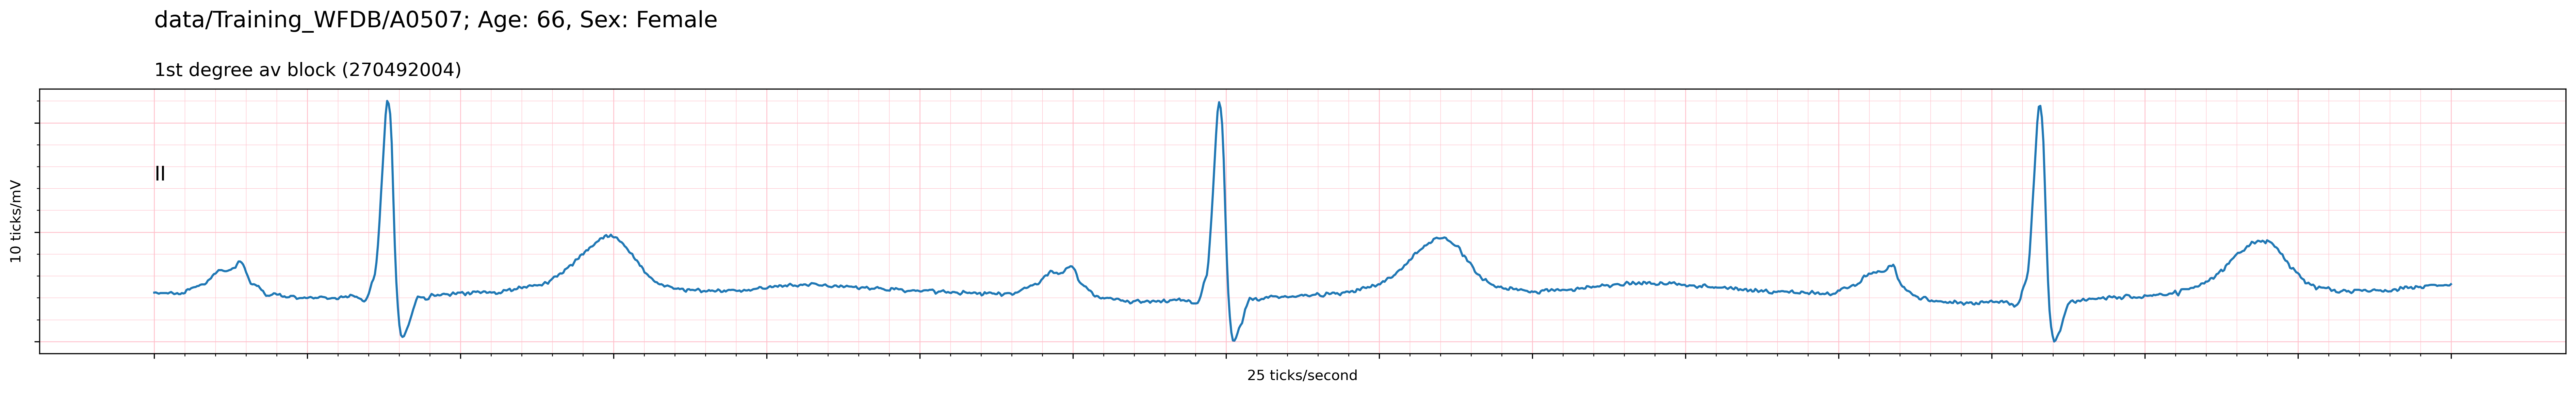

In [49]:

def plot_readable_signal_lead(signal, age, sex, fs, dx, file_path, signal_name="II"):
    """Plot a single lead such that there are 25 ticks per second and 10 ticks per mV.
    """
    num_samples, = signal.shape
    duration = len(signal) / fs

    print(f"{num_samples} samples, {fs} Hz -> {duration} s")
    if duration > 3:
        half_way = num_samples / 2
        five_sec_len = fs * 1.5
        print(f"too long, truncating to {half_way - five_sec_len, half_way + five_sec_len}")
        signal = signal[int(half_way - five_sec_len):int(half_way + five_sec_len)]
        num_samples,  = signal.shape
        duration = len(signal) / fs
        print(f"{num_samples} samples, {fs} Hz -> {duration} s")

    x = np.linspace(0, duration, num_samples)
    q_x = num_samples // 4    # plot column separator width
    
    # calculate the bottom-most row (II)
    disp_main = signal[:] - np.mean(signal[:])

    # how many x ticks?
    num_small_x_ticks = int(duration * 25) + 1
    small_x_ticks = np.linspace(0, duration, num_small_x_ticks)
    big_x_ticks = [x for (idx, x) in enumerate(small_x_ticks) if idx % 5 == 0]
    
    # how many y ticks?
    mV_range = np.max(disp_main) - np.min(disp_main)
    num_small_y_ticks = int(mV_range * 10) + 1
    small_y_ticks = np.linspace(np.min(disp_main), np.max(disp_main), num_small_y_ticks)
    big_y_ticks = [y for (idx, y) in enumerate(small_y_ticks) if idx % 5 == 0]

    # square out the ticks for display
    tick_ratio = num_small_x_ticks / num_small_y_ticks
    fig, ax = plt.subplots(figsize=(tick_ratio * 4, 4), dpi=300)
    
    # plot the 12 signals
    ax.plot(x, disp_main)  # Main    
    # annotate the 12 signals
    text_kwargs = {"horizontalalignment": "left",
                   "verticalalignment": "bottom", "fontsize": 14}

    ax.text(x[0 * q_x], disp_main[0] + 0.5, signal_name, **text_kwargs)  # MAIN

    # draw the gridlines
    ax.set_xticks(small_x_ticks, minor=True)
    ax.set_xticks(big_x_ticks, minor=False)
    ax.set_xticklabels(())

    ax.set_yticks(small_y_ticks, minor=True)
    ax.set_yticks(big_y_ticks, minor=False)
    ax.set_yticklabels(())

    ax.grid(b=True, which="major", axis="both",
            color="pink", linestyle="solid", linewidth=0.6)
    ax.grid(b=True, which="minor", axis="both",
            color="pink", linestyle="solid", linewidth=0.3)

    ax.set_xlabel("25 ticks/second")
    ax.set_ylabel("10 ticks/mV")

    # plot relevant metadata
    disp_sex = "Male" if sex == 0 else "Female"
    disp_str = f"{file_path}; Age: {age}, Sex: {disp_sex}\n"
    ax.text(0, np.max(disp_main) + 0.2, disp_str, {
        "horizontalalignment": "left",
        "verticalalignment": "bottom", "fontsize": 16
    })

    dx_str = []
    for dx_code in dx:
        dx_str.append(f"{snomed_map[str(dx_code)][1]} ({dx_code})")
    dx_str = ", ".join(dx_str)
    ax.text(0, np.max(disp_main) + 0.1, dx_str, {
        "horizontalalignment": "left",
        "verticalalignment": "bottom", "fontsize": 13
    })
    
    return ax


signal, age, sex, fs, dx = get_signal(3957)
plot_readable_signal_lead(
    signal[:,1],
    age,
    sex,
    fs,
    dx,
    record_files[3957],
    signal_name="II"
)
plt.tight_layout()
plt.savefig("fig/IAVB_notched_p_wave.pdf")
plt.show()

